In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train_df = pd.read_csv("preprocessed_train.csv", encoding='euc-kr')

In [3]:
train_df.head()

,분석데이터,label,numstrings,avlength,printables,entropy,paths,urls,registry,MZ,...,dist_86,dist_87,dist_88,dist_89,dist_90,dist_91,dist_92,dist_93,dist_94,dist_95
0,1,1,144,12.298611,1771,5.356616,0,0,0,1,...,10,4,10,9,4,0,1,0,0,0
1,2,1,804,9.580846,7703,6.063542,0,0,0,6,...,43,121,84,78,47,36,40,45,27,36
2,3,0,2205,12.736054,28083,6.107050,9,0,0,6,...,326,268,239,286,199,148,154,37,48,36
3,4,0,2602,10.288240,26770,5.373013,8,0,0,1,...,336,230,206,245,76,0,26,702,1,5
4,5,1,8980,23.252339,208806,5.775223,0,28,16,3,...,731,882,1171,1010,322,64,327,84,75,244


In [4]:
train_df.dtypes

분석데이터           int64
label           int64
numstrings      int64
avlength      float64
printables      int64
               ...   
dist_91         int64
dist_92         int64
dist_93         int64
dist_94         int64
dist_95         int64
Length: 618, dtype: object

In [5]:
train_df2 = train_df.drop(columns=['분석데이터'], axis=1)

In [6]:
train_df_x = train_df2.drop(['label'], axis=1)

In [7]:
train_df_y = train_df2['label']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train_df_x, train_df_y, test_size=0.2, random_state=42)

In [9]:
xgb = XGBClassifier(silent=False,
                    n_estimators = 1000,
                    booster='gbtree',
                    tree_method='gpu_hist',
                    preidctor= 'gpu_predictor',
                    scale_pos_weight=1,
                    learning_rate=0.01,
                    objective='binary:logistic',
                    max_depth = 10,
                    subsample = 0.8,
                    colsample_bytree = 0.8,
                    min_child_weight = 1,
                    gamma = 0.5, seed=42)
knn = KNeighborsClassifier(n_neighbors=3)
forest = RandomForestClassifier(n_estimators=500, random_state=42)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=300)

## robustScaler()

In [10]:
robustScaler = RobustScaler()

In [11]:
robustScaler.fit(x_train)

RobustScaler()

In [12]:
x_train_scaled = robustScaler.transform(x_train)

In [13]:
x_test_scaled = robustScaler.transform(x_test)

In [148]:
x_train_scaled

array([[-0.33043999,  0.14514185, -0.25795202, ..., -0.22972973,
        -0.22065728, -0.19327731],
       [-0.20862017,  0.11255379, -0.13148089, ..., -0.16666667,
        -0.12206573,  0.55042017],
       [ 2.90002993, -0.62817468,  1.16978689, ...,  3.48648649,
         5.51173709,  3.68067227],
       ...,
       [-0.32714756,  0.48669836, -0.24821648, ..., -0.22972973,
        -0.23004695, -0.19747899],
       [-0.24154445, -0.44869647, -0.21471577, ..., -0.1036036 ,
        -0.15023474, -0.08823529],
       [ 0.52529183,  0.3231182 ,  0.78192166, ..., -0.17117117,
        -0.18779343, -0.17226891]])

In [14]:
pred = xgb.fit(x_train_scaled, y_train).predict(x_test_scaled)

[16:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       900
           1       0.92      0.94      0.93      1100

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [16]:
accuracy_score(y_test, pred)

0.924

In [17]:
confusion_matrix(y_test, pred)

array([[ 816,   84],
       [  68, 1032]], dtype=int64)

## CV stacking ensemble

In [18]:
from vecstack import StackingTransformer

In [19]:
estimators = [
    ('KNN' , knn ),
    ('RandomForest' , forest),
    ('DecisionTree' , dt_clf),
    ('XGBoost' , xgb),
    ('AdaBoost', ada_clf)
]

In [20]:
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = accuracy_score, 
                            n_folds = 5, stratified = True, shuffle = True, 
                            random_state = 0)

In [21]:
stack = stack.fit(x_train, y_train)

[16:33:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:33:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some pa

In [22]:
s_train = stack.transform(x_train)
s_test = stack.transform(x_test)

In [23]:
s_model = xgb.fit(s_train, y_train)
s_model_prediction =  s_model.predict(s_test)
accuracy = round(accuracy_score(y_test, s_model_prediction) * 100, 5) 
print("Accuracy : ", accuracy, "%") 

[16:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :  92.5 %


## scaled 된 데이터로 다시 모델링 해보기

### robustScaler 적용

In [24]:
robustScaler.fit(x_train)
x_train_scaled = robustScaler.transform(x_train)
x_test_scaled = robustScaler.transform(x_test)

In [25]:
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.809

In [26]:
knn.fit(x_train_scaled, y_train)
knn.score(x_test_scaled, y_test)

0.7495

In [27]:
forest.fit(x_train, y_train)
forest.score(x_test, y_test)

0.9025

In [28]:
forest.fit(x_train_scaled, y_train)
forest.score(x_test_scaled, y_test)

0.902

In [29]:
dt_clf.fit(x_train,y_train)
dt_clf.score(x_test, y_test)

0.847

In [30]:
dt_clf.fit(x_train_scaled, y_train)
dt_clf.score(x_test_scaled, y_test)

0.8475

In [31]:
ada_clf.fit(x_train, y_train)
ada_clf.score(x_test, y_test)

0.883

In [32]:
ada_clf.fit(x_train_scaled, y_train)
ada_clf.score(x_test_scaled, y_test)

0.883

In [33]:
xgb.fit(x_train, y_train)
xgb.score(x_test, y_test)

[16:48:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:48:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.924

In [34]:
xgb.fit(x_train_scaled, y_train)
xgb.score(x_test_scaled, y_test)

[16:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.924

### MinMaxScaler 적용

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [37]:
dt_clf.fit(x_train,y_train)
dt_clf.score(x_test, y_test)

0.8565

In [38]:
dt_clf.fit(x_train_scaled, y_train)
dt_clf.score(x_test_scaled, y_test)

0.852

In [39]:
xgb.fit(x_train_scaled, y_train)
xgb.score(x_test_scaled, y_test)

[16:50:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:50:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.924

## scaled 된 데이터로 stacking ensemble 적용

In [40]:
stack = stack.fit(x_train_scaled, y_train)

[16:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some pa

In [41]:
s_train = stack.transform(x_train_scaled)
s_test = stack.transform(x_test_scaled)

In [42]:
s_model = xgb.fit(s_train, y_train)
s_model_prediction =  s_model.predict(s_test)
accuracy = round(accuracy_score(y_test, s_model_prediction) * 100, 3) 
print("Accuracy : ", accuracy, "%") 

[17:05:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :  92.5 %


In [43]:
s_model = xgb.fit(s_train, y_train)
s_model_prediction =  s_model.predict(s_test)
accuracy = round(accuracy_score(y_test, s_model_prediction) * 100, 5) 
print("Accuracy : ", accuracy, "%") 

[17:05:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :  92.5 %


## RFE 특성 선택 적용

In [44]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold

In [45]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [47]:
# select = RFECV(forest, cv=cv)
select = RFE(xgb, n_features_to_select=500, step=10)

In [48]:
select.fit(x_train, y_train)

[17:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some pa

[17:29:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=0.8, gamma=0.5, gpu_id=0,
                            importance_type='gain', interaction_constraints='',
                            learning_rate=0.01, max_delta_step=0, max_depth=10,
                            min_child_weight=1, missing=nan,
                            monotone_constraints='()', n_estimators=1000,
                            n_jobs=12, num_parallel_tree=1,
                            preidctor='gpu_predictor', random_state=42,
                            reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                            seed=42, silent=False, subsample=0.8,
                            tree_method='gpu_hist', validate_parameters=1,
                            verbosity=None),
    n_features_to_select=500, step=10)

In [49]:
x_train_rfe = select.transform(x_train)
x_test_rfe = select.transform(x_test)

In [50]:
rfe_modeling = forest.fit(x_train_rfe, y_train)

In [51]:
pred_rfe = forest.predict(x_test_rfe)

In [52]:
rfe_modeling.score(x_test_rfe, y_test)

0.908

In [53]:
accuracy_score(y_test, pred_rfe)

0.908

In [54]:
confusion_matrix(y_test, pred_rfe)

array([[ 808,   92],
       [  92, 1008]], dtype=int64)

In [56]:
pred = xgb.fit(x_train_rfe, y_train).predict(x_test_rfe)

[17:34:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:34:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [57]:
accuracy_score(y_test, pred)

0.9285

In [58]:
confusion_matrix(y_test, pred)

array([[ 821,   79],
       [  64, 1036]], dtype=int64)

## 특성 선택된 데이터로 다시 stacking ensemble 적용

In [59]:
estimators = [
    ('KNN' , knn ),
    ('RandomForest' , forest),
    ('DecisionTree' , dt_clf),
    ('XGBoost' , xgb),
    ('AdaBoost', ada_clf)
]

In [60]:
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.809

In [61]:
knn.fit(x_train_rfe, y_train)
knn.score(x_test_rfe, y_test)

0.843

In [62]:
forest.fit(x_train, y_train)
forest.score(x_test, y_test)

0.9025

In [63]:
forest.fit(x_train_rfe, y_train)
forest.score(x_test_rfe, y_test)

0.908

In [64]:
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.853

In [65]:
dt_clf.fit(x_train_rfe, y_train)
dt_clf.score(x_test_rfe, y_test)

0.853

In [66]:
stack = stack.fit(x_train_rfe, y_train)

[17:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some pa

In [67]:
s_train = stack.transform(x_train_rfe)
s_test = stack.transform(x_test_rfe)

In [68]:
s_model = forest.fit(s_train, y_train)
s_model_prediction =  s_model.predict(s_test)
accuracy = round(accuracy_score(y_test, s_model_prediction) * 100, 5)
print("Accuracy : ", accuracy, "%")

Accuracy :  92.45 %


## 일변량 통계로 특성 선택하기

In [69]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [70]:
select2 = SelectPercentile(score_func=f_classif, percentile=50)
select2.fit(x_train, y_train)

SelectPercentile(percentile=50)

In [71]:
select2_x = select2.transform(x_train)
select2_x_test = select2.transform(x_test)

In [72]:
xgb.fit(select2_x, y_train)

[17:49:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:49:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              preidctor='gpu_predictor', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=False,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [73]:
pred = xgb.predict(select2_x_test)

In [74]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       900
           1       0.92      0.93      0.92      1100

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [75]:
accuracy_score(y_test, pred)

0.917

In [76]:
confusion_matrix(y_test, pred)

array([[ 811,   89],
       [  77, 1023]], dtype=int64)

## featrure_importance 시각화와 그에 따른 이상치(outlier) 제거

In [78]:
xgb.fit(x_train, y_train)
knn.fit(x_train, y_train)
forest.fit(x_train, y_train)
dt_clf.fit(x_train, y_train)
ada_clf.fit(x_train, y_train)

[18:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier(n_estimators=300)

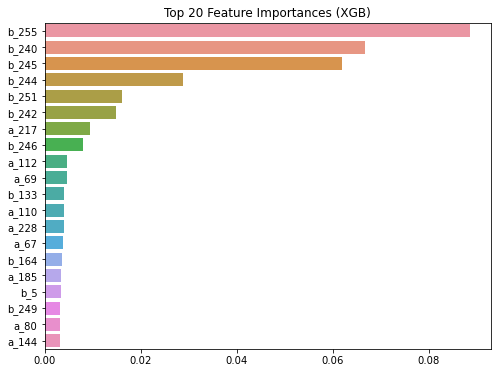

In [79]:
ft_importance_values = xgb.feature_importances_

ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances (XGB)')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

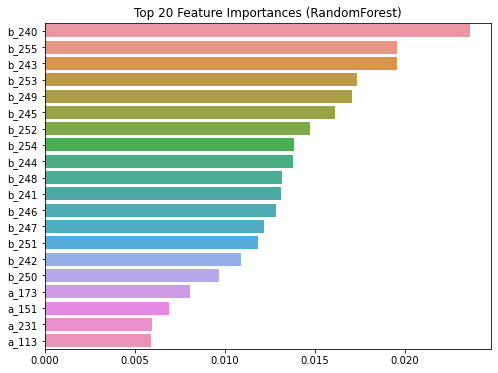

In [80]:
ft_importance_values = forest.feature_importances_

ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances (RandomForest)')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

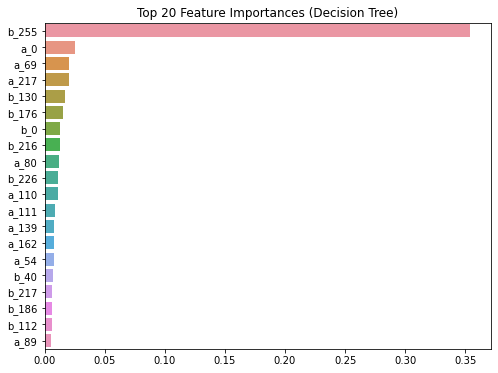

In [81]:
ft_importance_values = dt_clf.feature_importances_

ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances (Decision Tree)')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

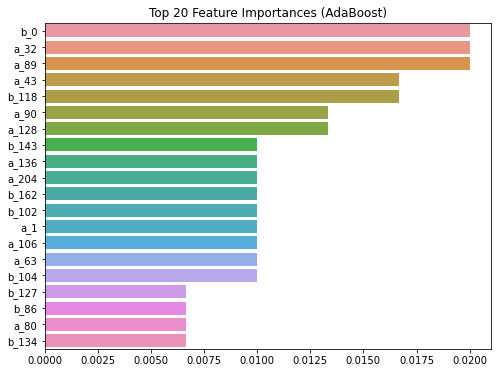

In [82]:
ft_importance_values = ada_clf.feature_importances_

ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances (AdaBoost)')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [83]:
"""
f,ax = plt.subplots(ncols=2, figsize=(15,8))

sns.boxplot(x='label', y='b_255', data=train_df, ax=ax[0])
ax[0].set_title('b_255 vs label')

sns.boxplot(x='label', y='b_240', data=train_df, ax=ax[1])
ax[0].set_title('b_240 vs label')
"""

"\nf,ax = plt.subplots(ncols=2, figsize=(15,8))\n\nsns.boxplot(x='label', y='b_255', data=train_df, ax=ax[0])\nax[0].set_title('b_255 vs label')\n\nsns.boxplot(x='label', y='b_240', data=train_df, ax=ax[1])\nax[0].set_title('b_240 vs label')\n"

In [84]:
data_copy = train_df2.copy()

In [85]:
def remove_outlier_0(df, column):
    fraud_column_data = df[df['label']==0][column]
    quantile_25 = np.percentile(fraud_column
                                _data.values, 25)
    quantile_75 = np.percentile(fraud_column_data.values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * 1.5
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    outlier_idx = fraud_column_data[ (fraud_column_data < lowest) | (fraud_column_data > highest) ].index
    print(len(outlier_idx))
    df.drop(outlier_idx, axis=0, inplace=True)
    print(df.shape)
    return df

In [86]:
def remove_outlier_1(df, column):
    fraud_column_data = df[df['label']==1][column]
    quantile_25 = np.percentile(fraud_column_data.values, 25)
    quantile_75 = np.percentile(fraud_column_data.values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * 1.5
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    outlier_idx = fraud_column_data[ (fraud_column_data < lowest) | (fraud_column_data > highest) ].index
    print(len(outlier_idx))
    df.drop(outlier_idx, axis=0, inplace=True)
    print(df.shape)
    return df

In [87]:
data_copy = remove_outlier_0(data_copy, 'b_255')

972
(9028, 617)


In [88]:
data_copy_x = data_copy.drop(columns=['label'], axis=1)

In [89]:
data_copy_y = data_copy['label']

In [90]:
x_train, x_test, y_train, y_test = train_test_split(data_copy_x, data_copy_y, test_size=0.2, random_state=42)

In [91]:
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

[18:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [92]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       714
           1       0.98      0.94      0.96      1092

    accuracy                           0.95      1806
   macro avg       0.95      0.95      0.95      1806
weighted avg       0.95      0.95      0.95      1806



In [93]:
accuracy_score(y_test, pred)

0.9507198228128461

In [94]:
confusion_matrix(y_test, pred)

array([[ 692,   22],
       [  67, 1025]], dtype=int64)

In [95]:
forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [96]:
forest.score(x_test, y_test)

0.9318936877076412

In [97]:
data_copy = remove_outlier_1(data_copy, 'b_255')

630
(8398, 617)


In [98]:
data_copy_x = data_copy.drop(columns=['label'], axis=1)

In [99]:
data_copy_y = data_copy['label']

In [100]:
x_train, x_test, y_train, y_test = train_test_split(data_copy_x, data_copy_y, test_size=0.2, random_state=42)

In [101]:
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

[18:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [102]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       721
           1       0.98      0.93      0.95       959

    accuracy                           0.95      1680
   macro avg       0.95      0.95      0.95      1680
weighted avg       0.95      0.95      0.95      1680



In [103]:
accuracy_score(y_test, pred)

0.9488095238095238

In [104]:
confusion_matrix(y_test, pred)

array([[699,  22],
       [ 64, 895]], dtype=int64)

In [105]:
forest.fit(x_train, y_train)
forest.score(x_test, y_test)

0.9416666666666667

b_240의 이상치도 제거하고 시험해보기

In [106]:
data_copy = remove_outlier_0(data_copy, 'b_240')

796
(7602, 617)


In [107]:
data_copy = remove_outlier_1(data_copy, 'b_240')

805
(6797, 617)


In [108]:
data_copy_x = data_copy.drop(columns=['label'], axis=1)

In [109]:
data_copy_y = data_copy['label']

In [110]:
x_train, x_test, y_train, y_test = train_test_split(data_copy_x, data_copy_y, test_size=0.2, random_state=42)

In [125]:
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

[18:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [126]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       555
           1       1.00      0.96      0.98       805

    accuracy                           0.97      1360
   macro avg       0.97      0.98      0.97      1360
weighted avg       0.98      0.97      0.98      1360



In [127]:
accuracy_score(y_test, pred)

0.975

In [128]:
confusion_matrix(y_test, pred)

array([[554,   1],
       [ 33, 772]], dtype=int64)

In [129]:
forest.fit(x_train, y_train)
forest.score(x_test, y_test)

0.9661764705882353

In [132]:
confusion_matrix(y_test, pred)

array([[554,   1],
       [ 33, 772]], dtype=int64)

In [133]:
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.9419117647058823

In [134]:
confusion_matrix(y_test, pred)

array([[554,   1],
       [ 33, 772]], dtype=int64)

In [ ]:
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = accuracy_score, 
                            n_folds = 5, stratified = True, shuffle = True, 
                            random_state = 0)

In [136]:
estimators = [
    ('RandomForest' , forest),
    ('DecisionTree' , dt_clf),
    ('XGBoost' , xgb)
]

In [137]:
stack = stack.fit(x_train, y_train)

[18:45:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:45:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some pa

In [138]:
s_train = stack.transform(x_train)
s_test = stack.transform(x_test)

In [144]:
s_model = xgb.fit(s_train, y_train)
s_model_prediction =  s_model.predict(s_test)
accuracy = round(accuracy_score(y_test, s_model_prediction) * 100, 5)
print("Accuracy : ", accuracy, "%")

[18:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :  97.35294 %
